### Loading libraries

In [1]:
import sys
import os
sys.path.insert(1, '..')
os.chdir('..')

import matplotlib.pyplot as plt
from data_formatters.iglu import *
from dataset import TSDataset
from conf import Conf

/home/grads/m/mrsergazinov/.conda/envs/ccnf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Code walk-through

The major parts of the code that need to be defined for each data set are:
1. config file in `.yaml` format,
2. data formatter script.

For now, you can study the `electricity.yaml` example for a look of what a config file should feel like. You can skip the hyperparam defintions and the model parameters. The main focus would be on defining the dataset parameters. 

We do not intereact with `.yaml` in a direct way but instead though `Conf` class, which handles the following:
1. defines some defaults if not specified in `.yaml`,
2. sets save paths,
3. allows for nice colored printing.

Technically, we could doo all of this in the `.yaml` file directly. However, then every time we re-run the experiment, we would have to manually modify the `.yaml` file to reset save paths and redefine some variables, which would be inconvenient.  


In [2]:
# loading the config file, setting the experiment name, and the seed for random pre-processing parts (like splitting)
cnf = Conf(conf_file_path='./conf/iglu.yaml', seed=15, exp_name="IGLU", log=False)

In [3]:
# lets print out the config file
print(f'\nDefault configuration parameters: \n{cnf}')


Default configuration parameters: 
LR: 0.001
EPOCHS: 20
N_WORKERS: 0
BATCH_SIZE: 64
QUANTILES: [0.1, 0.5, 0.9]
DS_NAME: iglu_urjeet
ALL_PARAMS: {'ds_name': 'iglu_urjeet', 'data_csv_path': './raw_data/iglu_example_data_5_subject.csv', 'index_col': -1, 'total_time_steps': 192, 'num_encoder_steps': 168, 'max_samples': 5000, 'batch_size': 64, 'device': 'cuda', 'lr': 0.001, 'num_epochs': 20, 'n_workers': 0, 'model': 'transformer', 'loader': 'base', 'quantiles': [0.1, 0.5, 0.9], 'batch_first': True, 'early_stopping_patience': 5, 'hidden_layer_size': 160, 'stack_size': 1, 'dropout_rate': 0.1, 'max_gradient_norm': 0.01, 'num_heads': 4, 'd_model': 64, 'q': 16, 'v': 16, 'h': 4, 'N': 2, 'attention_size': 0, 'dropout': 0.1, 'pe': 'original', 'chunk_mode': 'None', 'd_input': 5, 'd_output': 3}
EXP_LOG_PATH: ./log/transformer/IGLU/11/04/2022.19:42:27
DEVICE: cuda


Now let's move on to the data formatter. This is the part that should handle:
1. loading the data and setting types,
2. splitting the data into train / val / test sets,
3. setting scalers and encoders for numerical / categorical variables resp.

We are going to leave parts 2-3 for the future exploration. Now, let's focus on loading and settting the types for the data. 

In [4]:
# call the data fromatter directly
data_formatter = IGLUFormatter(cnf)

Dropped segments: 11
Extracted segments: 21


In [5]:
data_formatter.data.head(10)

,time,id,gl,segment,id_segment,year,month,day,hour,minute
0,2015-06-06 16:50:00,0,153.000000,0.0,Subject 1_0.0,2015,6,6,16,50
1,2015-06-06 16:55:00,0,147.666667,0.0,Subject 1_0.0,2015,6,6,16,55
2,2015-06-06 17:00:00,0,142.333333,0.0,Subject 1_0.0,2015,6,6,17,0
3,2015-06-06 17:05:00,0,137.000000,0.0,Subject 1_0.0,2015,6,6,17,5
4,2015-06-06 17:10:00,0,128.000000,0.0,Subject 1_0.0,2015,6,6,17,10
5,2015-06-06 17:15:00,0,121.000000,0.0,Subject 1_0.0,2015,6,6,17,15
6,2015-06-06 17:20:00,0,120.500000,0.0,Subject 1_0.0,2015,6,6,17,20
7,2015-06-06 17:25:00,0,120.000000,0.0,Subject 1_0.0,2015,6,6,17,25
8,2015-06-06 17:30:00,0,124.500000,0.0,Subject 1_0.0,2015,6,6,17,30
9,2015-06-06 17:35:00,0,129.000000,0.0,Subject 1_0.0,2015,6,6,17,35


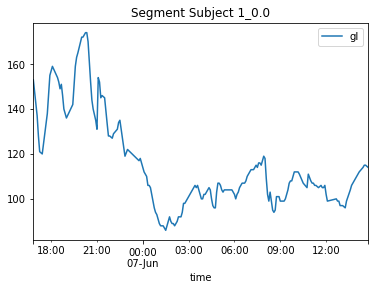

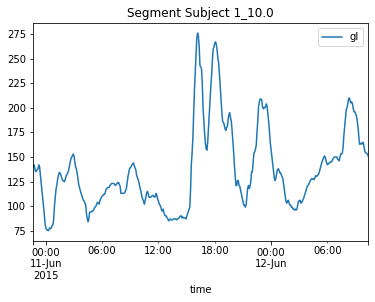

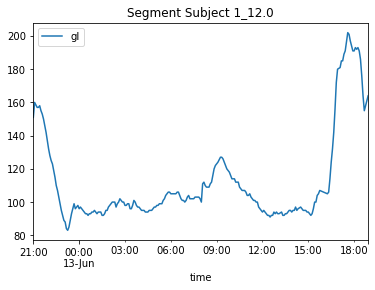

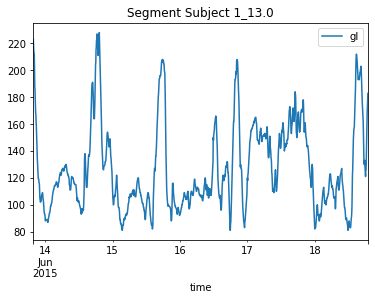

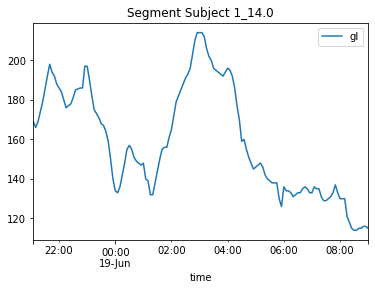

In [6]:
# plot the data inside the data formatter
counter = 0
for id_segment, df in data_formatter.data.groupby('id_segment'):
    # print(id_segment)
    df.plot(x='time', y='gl', title=f'Segment {id_segment}')
    plt.show()
    counter += 1
    if(counter == 5): break

In [7]:
# let's see train, val, and test numbers
print(f'Train / val / test indices: {len(data_formatter.train_idx)}, {len(data_formatter.val_idx)}, {len(data_formatter.test_idx)}')
# let's see proprtions
print(f'Train / val / test proportions: {len(data_formatter.train_idx) / len(data_formatter.data)}, {len(data_formatter.val_idx) / len(data_formatter.data)}, {len(data_formatter.test_idx) / len(data_formatter.data)}')

Train / val / test indices: 8575, 2112, 3068
Train / val / test proportions: 0.6097127417519909, 0.15017064846416384, 0.21814562002275312


Finally, let's work with the `TSDataset` class. This is the main part of the code as it aligns all of our previous steps. In the end, it is the `TSDataset` that is going to call the splitters, scalers, and encoders. **Importatnly** the model is only going to interact with the data through this class. 

In [8]:
# we are going to pass our data formatter and the config file to the TSDataset class
train_dataset = TSDataset(cnf, data_formatter, 'train')
val_dataset = TSDataset(cnf, data_formatter, 'val')
test_dataset = TSDataset(cnf, data_formatter, 'test')

Getting valid sampling locations.
# available segments=5710
Extracting 5000 samples out of 5710
1000 of 5000 samples done...
2000 of 5000 samples done...
3000 of 5000 samples done...
4000 of 5000 samples done...
5000 of 5000 samples done...
Getting valid sampling locations.
# available segments=11
Extracting all available segments.
Getting valid sampling locations.
# available segments=776
Extracting all available segments.


Example #0: x.shape=(192, 6), y.shape=(24, 1)
Example #1: x.shape=(192, 6), y.shape=(24, 1)
Example #2: x.shape=(192, 6), y.shape=(24, 1)
Example #3: x.shape=(192, 6), y.shape=(24, 1)
Example #4: x.shape=(192, 6), y.shape=(24, 1)
Example #5: x.shape=(192, 6), y.shape=(24, 1)
Example #6: x.shape=(192, 6), y.shape=(24, 1)
Example #7: x.shape=(192, 6), y.shape=(24, 1)
Example #8: x.shape=(192, 6), y.shape=(24, 1)
Example #9: x.shape=(192, 6), y.shape=(24, 1)


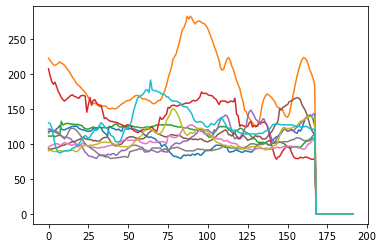

In [9]:
# now let's see how we can sample minibatches from our dataset that we can then pass to the model to train on
for i in range(10):
    # 192 x ['power_usage', 'hour', 'day_of_week', 'hours_from_start', 'categorical_id']
    x = train_dataset[i]['inputs']
    # 24 x ['power_usage']
    y = train_dataset[i]['outputs']
    print(f'Example #{i}: x.shape={x.shape}, y.shape={y.shape}')
    plt.plot(x[:, 5])